# Visualizing Pneumonia using Deep Learning
By Derek Lilienthal

**Description of notebook** <br>
In this notebook, I implement a Deep Convolutional Model and visualize the predictions using the Grad-CAM Visualization method on X-rays of patients with and without Pneumonia.

**Task**<br>
To predict Pneumonia using X-rays.

**Model**<br>
I implemented a deep neural network using 4 stacked Convolutionals and their residuals.

I also used GPU acceleration through a RTX 3080 Laptop (12GB) for training.

**Link to data**
https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset

<hr>

**Imports**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder 
import tensorflow as tf
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

plt.style.use('ggplot')

*Makes the notebook full-screen* 

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

The data that was downloaded is stored in a *data* directory

In [3]:
data_dir = 'data' 
os.listdir(data_dir)

['Chest_xray_Corona_dataset_Summary.csv',
 'Chest_xray_Corona_Metadata.csv',
 'Coronahack-Chest-XRay-Dataset']

### Descriptions of the data

In [4]:
summary = pd.read_csv(os.path.join(data_dir, 'Chest_xray_Corona_dataset_Summary.csv'), index_col=0)
summary

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,NaN,NaN,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,NaN,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,NaN,2772
6,Pnemonia,bacteria,Streptococcus,5


**Metadata**

In [5]:
metadata = pd.read_csv(os.path.join(data_dir, 'Chest_xray_Corona_Metadata.csv'), index_col=0)
metadata

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


**Training dataset**

In [6]:
train_df = metadata[metadata['Dataset_type'] == 'TRAIN']
train_df = train_df.convert_dtypes()
train_df

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,<NA>,<NA>
1,IM-0127-0001.jpeg,Normal,TRAIN,<NA>,<NA>
2,IM-0125-0001.jpeg,Normal,TRAIN,<NA>,<NA>
3,IM-0122-0001.jpeg,Normal,TRAIN,<NA>,<NA>
4,IM-0119-0001.jpeg,Normal,TRAIN,<NA>,<NA>
...,...,...,...,...,...
5304,1-s2.0-S0929664620300449-gr2_lrg-c.jpg,Pnemonia,TRAIN,COVID-19,Virus
5305,1-s2.0-S0929664620300449-gr2_lrg-b.jpg,Pnemonia,TRAIN,COVID-19,Virus
5306,1-s2.0-S0929664620300449-gr2_lrg-a.jpg,Pnemonia,TRAIN,COVID-19,Virus
5307,1-s2.0-S0140673620303706-fx1_lrg.jpg,Pnemonia,TRAIN,COVID-19,Virus


**Looking at the different number of labels in the training dataset**

*Different labels*

Pnemonia    3944
Normal      1342
Name: Label, dtype: Int64


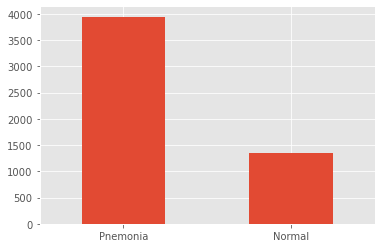

In [7]:
print(train_df['Label'].value_counts())
train_df['Label'].value_counts().plot.bar()
plt.xticks(rotation=0);

The data is imbalanced with the majority of X-rays having Pneumonia. 

*Virus label 1*

bacteria          2535
Virus             1407
NaN               1342
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: Int64


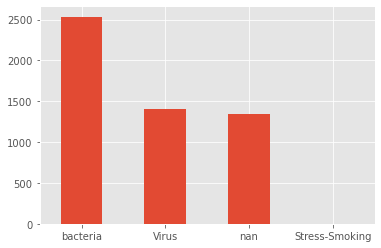

In [8]:
print(train_df['Label_1_Virus_category'].value_counts(dropna=False))
train_df['Label_1_Virus_category'].value_counts(dropna=False).plot.bar()
plt.xticks(rotation=0);

The majority of cases are from bacteria and viruses with almost no *Stress-Smoking* X-rays

*Virus label 2*

NaN              5217
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: Int64


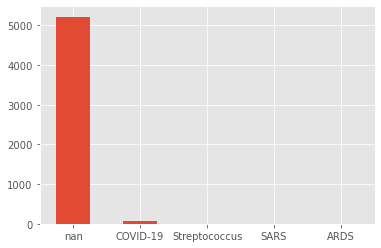

In [9]:
print(train_df['Label_2_Virus_category'].value_counts(dropna=False))
train_df['Label_2_Virus_category'].value_counts(dropna=False).plot.bar()
plt.xticks(rotation=0);

Almost all of the observations do not have the kind of virus identified.

**Testing dataset**

In [10]:
test_df = metadata[metadata['Dataset_type'] == 'TEST']
test_df = test_df.convert_dtypes()
test_df

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
5309,IM-0021-0001.jpeg,Normal,TEST,<NA>,<NA>
5310,IM-0019-0001.jpeg,Normal,TEST,<NA>,<NA>
5311,IM-0017-0001.jpeg,Normal,TEST,<NA>,<NA>
5312,IM-0016-0001.jpeg,Normal,TEST,<NA>,<NA>
5313,IM-0015-0001.jpeg,Normal,TEST,<NA>,<NA>
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,<NA>,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,<NA>,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,<NA>,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,<NA>,Virus


**Looking at the different number of labels in the testing dataset**

*Different Labels*

Pnemonia    390
Normal      234
Name: Label, dtype: Int64


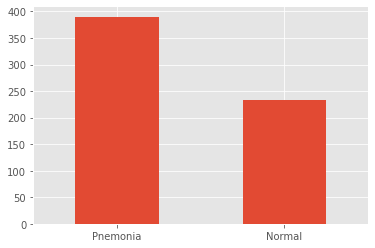

In [11]:
print(test_df['Label'].value_counts())
test_df['Label'].value_counts().plot.bar()
plt.xticks(rotation=0);

The testing data is also imbalanced

*Virus label 1*

bacteria    242
NaN         234
Virus       148
Name: Label_1_Virus_category, dtype: Int64


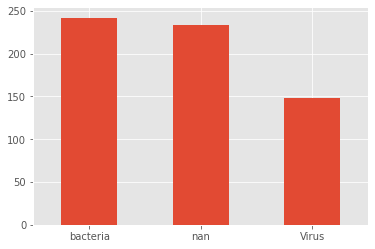

In [12]:
print(test_df['Label_1_Virus_category'].value_counts(dropna=False))
test_df['Label_1_Virus_category'].value_counts(dropna=False).plot.bar()
plt.xticks(rotation=0);

There is an almost even amount of bacteria Pneumonia observations with bacteria as there is observations with *nan*

*Virus label 2*

NaN    624
Name: Label_2_Virus_category, dtype: Int64


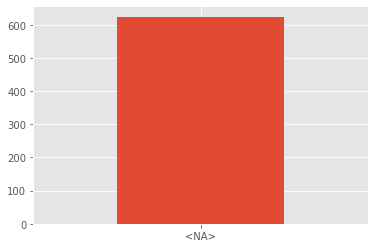

In [13]:
print(test_df['Label_2_Virus_category'].value_counts(dropna=False))
test_df['Label_2_Virus_category'].value_counts(dropna=False).plot.bar()
plt.xticks(rotation=0);

None of the testing cases have a virus identified

**Creating directory paths for the training and testing datasets**

In [14]:
train_dir = os.path.join(os.path.join(data_dir, 'Coronahack-Chest-XRay-Dataset'), 'train')
test_dir = os.path.join(os.path.join(data_dir, 'Coronahack-Chest-XRay-Dataset'), 'test')
print(train_dir)
print(test_dir)

data\Coronahack-Chest-XRay-Dataset\train
data\Coronahack-Chest-XRay-Dataset\test


### Looking at random X-rays

In [15]:
def display_xray():
    rand_example = np.random.choice(train_df.shape[0])
    img = load_img(os.path.join(train_dir, train_df['X_ray_image_name'][rand_example]))
    # Plotting the image
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.title(train_df['Label'][rand_example])
    plt.axis("off")

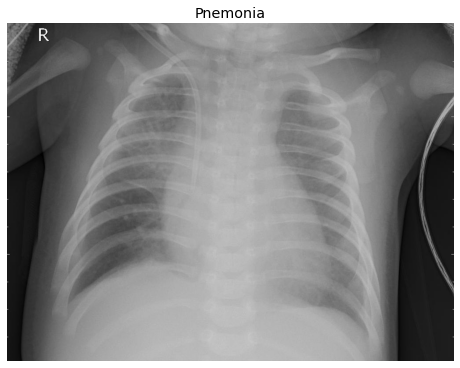

In [16]:
display_xray()

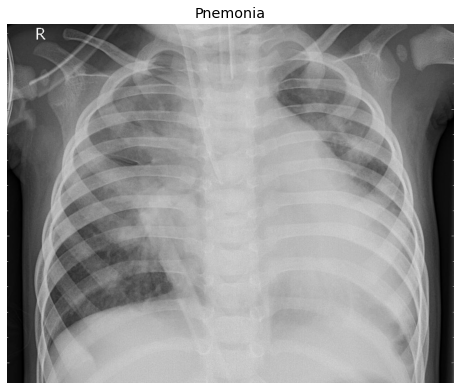

In [17]:
display_xray()

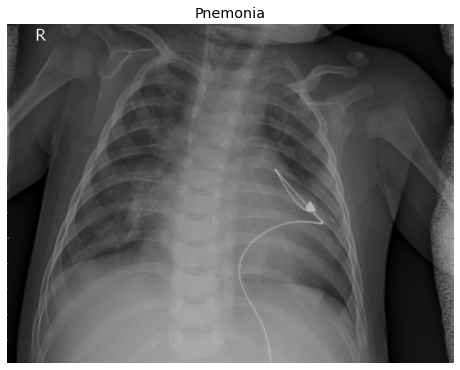

In [18]:
display_xray()

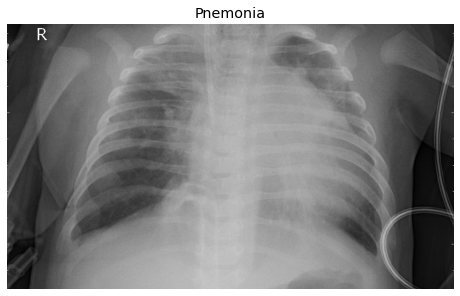

In [19]:
display_xray()

### Removing X-rays that are different from the rest

There are a handful of images that do not follow a typical chest X-ray where the patient is captured with their chest facing towards the machine. Below, I remove those examples from the training set

In [20]:
img_to_remove = ["1-s2.0-S0929664620300449-gr3_lrg-a.jpg",
                "1-s2.0-S0929664620300449-gr3_lrg-b.jpg",
                "1-s2.0-S0929664620300449-gr3_lrg-c.jpg",
                "1-s2.0-S0929664620300449-gr3_lrg-d.jpg",
                "3ED3C0E1-4FE0-4238-8112-DDFF9E20B471.jpeg",
                "4C4DEFD8-F55D-4588-AAD6-C59017F55966.jpeg",
                "6A7D4110-2BFC-4D9A-A2D6-E9226D91D25A.jpeg",
                "21DDEBFD-7F16-4E3E-8F90-CB1B8EE82828.jpeg",
                "191F3B3A-2879-4EF3-BE56-EE0D2B5AAEE3.jpeg",
                "396A81A5-982C-44E9-A57E-9B1DC34E2C08.jpeg",
                "5083A6B7-8983-472E-A427-570A3E03DDEE.jpeg",
                "66298CBF-6F10-42D5-A688-741F6AC84A76.jpeg",
                "925446AE-B3C7-4C93-941B-AC4D2FE1F455.jpeg"]

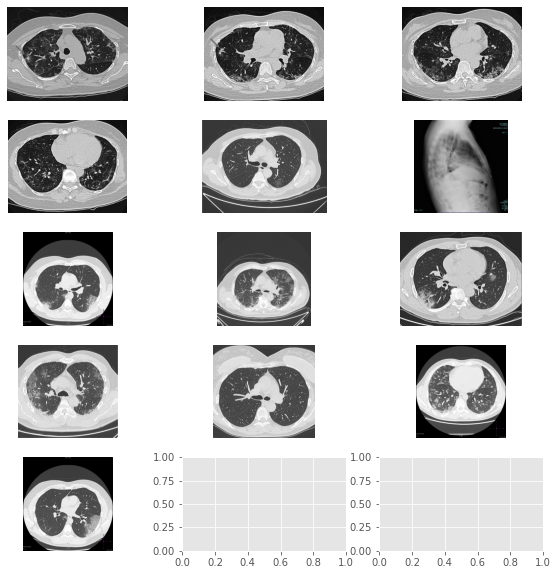

In [21]:
img_arr = []
for img in img_to_remove:
    img_arr.append(img_to_array(load_img(os.path.join(train_dir, img))))

# plotting the images
counter = 0
fig, axes = plt.subplots(5,3, figsize=(10, 10))
for x in range(5):
    for y in range(3):
        if counter < len(img_arr):
            plt.sca(axes[x, y])
            plt.imshow(np.array(img_arr[counter]).astype('uint8'))
            plt.axis("off")
            counter += 1
        
plt.show()

*Removing them*

In [22]:
for img in img_to_remove:
    index_to_remove = train_df[train_df['X_ray_image_name'].str.contains(img)].index
    train_df.drop(index=index_to_remove, inplace=True)
    
train_df.reset_index(inplace=True, drop=True)

### Encoding labels

First I will replace the missing values

In [23]:
train_df['Label_1_Virus_category'] = train_df['Label_1_Virus_category'].replace(np.nan, 'None')
train_df['Label_2_Virus_category'] = train_df['Label_2_Virus_category'].replace(np.nan, 'None')
test_df['Label_1_Virus_category'] = test_df['Label_1_Virus_category'].replace(np.nan, 'None')
test_df['Label_2_Virus_category'] = test_df['Label_2_Virus_category'].astype('float').replace(np.nan, 'None')

Encoding the labels

In [24]:
label = LabelEncoder()
Label_1_Virus = LabelEncoder()
Label_2_Virus = LabelEncoder()

label_enc = label.fit_transform(train_df['Label'])
Label_1_Virus_enc = Label_1_Virus.fit_transform(train_df['Label_1_Virus_category'])
Label_2_Virus_enc = Label_2_Virus.fit_transform(train_df['Label_2_Virus_category'])

train_df['Label'] = label_enc
train_df['Label_1_Virus_category'] = Label_1_Virus_enc
train_df['Label_2_Virus_category'] = Label_2_Virus_enc

test_df['Label'] = label.fit_transform(test_df['Label'])
test_df['Label_1_Virus_category'] = Label_1_Virus.transform(test_df['Label_1_Virus_category'])
test_df['Label_2_Virus_category'] = Label_2_Virus.transform(test_df['Label_2_Virus_category'])

In [25]:
for label, class_ in zip(set(label_enc), label.classes_):
    print(label, class_)

0 Normal
1 Pnemonia


In [26]:
for label, class_ in zip(set(Label_1_Virus_enc), Label_1_Virus.classes_):
    print(label, class_)

0 None
1 Stress-Smoking
2 Virus
3 bacteria


In [27]:
for label, class_ in zip(set(Label_2_Virus_enc), Label_2_Virus.classes_):
    print(label, class_)

0 ARDS
1 COVID-19
2 None
3 SARS
4 Streptococcus


**Shuffling the dataset**

In [28]:
train_df = train_df.sample(frac=1, random_state=43)
test_df = test_df.sample(frac=1, random_state=43)

**Droping the Dataset_type column and re-arranging the columns**

In [29]:
train_df = train_df[['Label', 'Label_2_Virus_category', 'Label_1_Virus_category', 'X_ray_image_name']]
test_df = test_df[['Label', 'Label_2_Virus_category', 'Label_1_Virus_category', 'X_ray_image_name']]
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)
train_df

,Label,Label_2_Virus_category,Label_1_Virus_category,X_ray_image_name
0,1,2,3,person1405_bacteria_3566.jpeg
1,1,2,2,person1188_virus_2024.jpeg
2,1,2,3,person1690_bacteria_4475.jpeg
3,1,2,3,person30_bacteria_155.jpeg
4,0,2,0,NORMAL2-IM-1202-0001.jpeg
...,...,...,...,...
5280,0,2,0,IM-0485-0001.jpeg
5281,1,2,3,person1280_bacteria_3243.jpeg
5282,1,2,2,person1494_virus_2601.jpeg
5283,1,2,3,person1502_bacteria_3924.jpeg


In [30]:
test_df

,Label,Label_2_Virus_category,Label_1_Virus_category,X_ray_image_name
0,1,2,2,person1628_virus_2821.jpeg
1,0,2,0,NORMAL2-IM-0045-0001.jpeg
2,0,2,0,NORMAL2-IM-0123-0001.jpeg
3,0,2,0,IM-0095-0001.jpeg
4,1,2,3,person152_bacteria_724.jpeg
...,...,...,...,...
619,0,2,0,NORMAL2-IM-0073-0001.jpeg
620,0,2,0,IM-0077-0001.jpeg
621,1,2,3,person152_bacteria_720.jpeg
622,1,2,2,person1610_virus_2793.jpeg


**Getting the images from the training and testing directory**

In [31]:
img_size = (180,180)

### Training images
img_arr = []
for img in tqdm(train_df.values[:,3]):
    img_arr.append(img_to_array(load_img(os.path.join(train_dir, img), target_size=img_size)) / 255)
img_arr = np.array(img_arr)
    
### Testing images
test_img_arr = []
for img in tqdm(test_df.values[:,3]):
    test_img_arr.append(img_to_array(load_img(os.path.join(test_dir, img), target_size=img_size)) / 255)
test_img_arr = np.array(test_img_arr)

100%|███████████████████████████████████████████████████████████████████████████████| 624/624 [00:04<00:00, 154.55it/s]


In [32]:
print(img_arr.shape)
print(test_img_arr.shape)

(5285, 180, 180, 3)
(624, 180, 180, 3)


**Making validation set**

In [33]:
# percentage_of_examples = 0.2

# val_num = int(train_df.shape[0] * percentage_of_examples)
# num_test_examples = train_df.shape[0] - val_num
# print(f'{percentage_of_examples*100}% of the {train_df.shape[0]} training data is {val_num} with {num_test_examples} training examples')

# test_img = np.array(img_arr).astype('float64')[:num_test_examples]
# val_img = np.array(img_arr).astype('float64')[num_test_examples:]

# test_labels = train_df.values[:,0].astype('float64')[:num_test_examples]
# test_labels_1_Virus_category = train_df.values[:,1].astype('float64')[:num_test_examples]
# test_labels_2_Virus_category = train_df.values[:,2].astype('float64')[:num_test_examples]

# val_labels = train_df.values[:,0].astype('float64')[num_test_examples:]
# val_labels_1_Virus_category = train_df.values[:,1].astype('float64')[num_test_examples:]
# val_labels_2_Virus_category = train_df.values[:,2].astype('float64')[num_test_examples:]

**Making a data augmentor**

This data augmentor will flip each image horizontally and give up to a -20 to +20 degree rotation. This helps the model generalize during training.

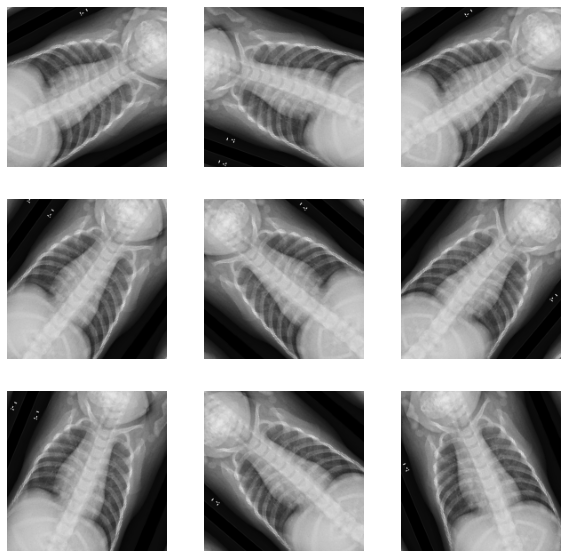

In [35]:
data_augmentation = Sequential(
    [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2)
    ]
)

# plotting the images
fig, axes = plt.subplots(3,3, figsize=(10, 10))
for x in range(3):
    for y in range(3):
        plt.sca(axes[x, y])
        plt.imshow(data_augmentation(test_img_arr[1].reshape(1, 180, 180, 3))[0])
        plt.axis("off");

*Helper function for visualizing the training and validation loss*

In [36]:
def plot_history(history):
    """This function plots the training and validation loss"""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.figure(figsize=(6,4))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    lowest_val_loss_epoch = np.argmin(val_loss)+1
    print("\nLowest Validation Loss: {:.4f} on epoch {}".format(np.min(val_loss), lowest_val_loss_epoch))

### Model 1 (Classifying for Pnemonia)

In [37]:
def make_model(filters=48, kernel_size=3, padding='same'):
    inputs = layers.Input(shape=((180, 180, 3)), name='Input')
    x = data_augmentation(inputs)
    
    residual = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.MaxPool2D((2,2), padding=padding)(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding=padding)(residual)
    x = layers.add([x, residual])
    
    residual = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.MaxPool2D((2,2), padding=padding)(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding=padding)(residual)
    x = layers.add([x, residual])
    
    residual = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.MaxPool2D((2,2), padding=padding)(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding=padding)(residual)
    x = layers.add([x, residual])
    
    residual = x
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, activation="relu", padding=padding)(x)
    x = layers.MaxPool2D((2,2), padding=padding)(x)
    residual = layers.Conv2D(filters, 1, strides=2, padding=padding)(residual)
    x = layers.add([x, residual])
    
    x = layers.Flatten()(x)
    output = layers.Dense(1, activation='sigmoid', name='output')(x)
    return Model(inputs, output)


tf.keras.backend.clear_session()

model = make_model(filters=48, kernel_size=3, padding='same')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 180, 180, 3)  0           Input[0][0]                      
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 180, 48) 1344        sequential_1[0][0]               
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 180, 180, 48) 20784       conv2d[0][0]                     
______________________________________________________________________________________________

*Showing the model*

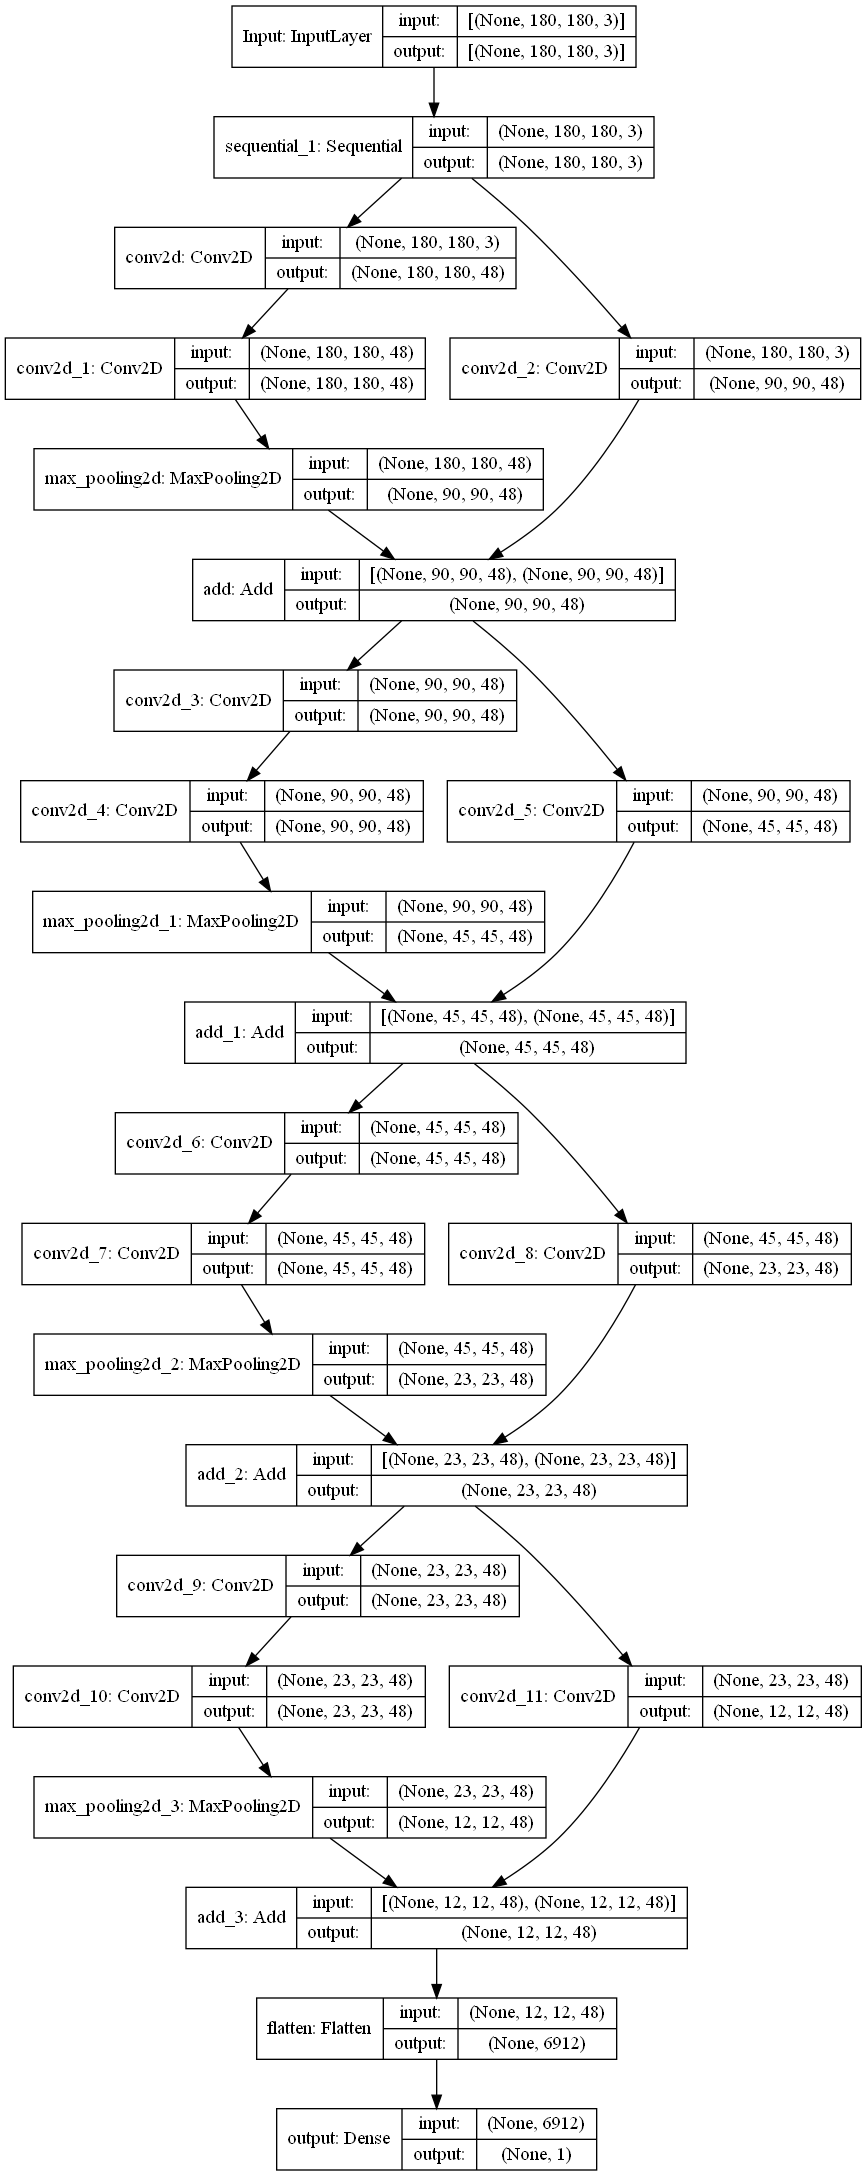

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Training

I will implement early stopping with restoring the best weights during the training process. 

In [39]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, # Stop after 3 epochs of no improvement
                               min_delta=0, 
                               mode='min', 
                               restore_best_weights=True, # Restore the best weights
                               verbose=1) 

# Saving the training history
history = model.fit(img_arr, 
                    train_df['Label'].values,  
                    epochs=75, 
                    batch_size=64,
                    callbacks=[early_stopping],
                    validation_split=0.2)

Epoch 1/75
67/67 [==============================] - 12s 120ms/step - loss: 0.5120 - accuracy: 0.7713 - val_loss: 0.3321 - val_accuracy: 0.8581
Epoch 2/75
67/67 [==============================] - 7s 103ms/step - loss: 0.3277 - accuracy: 0.8477 - val_loss: 0.2720 - val_accuracy: 0.8751
Epoch 3/75
67/67 [==============================] - 7s 103ms/step - loss: 0.2586 - accuracy: 0.8914 - val_loss: 0.2450 - val_accuracy: 0.8893
Epoch 4/75
67/67 [==============================] - 7s 102ms/step - loss: 0.2516 - accuracy: 0.8992 - val_loss: 0.2298 - val_accuracy: 0.9054
Epoch 5/75
67/67 [==============================] - 7s 103ms/step - loss: 0.2358 - accuracy: 0.9030 - val_loss: 0.3044 - val_accuracy: 0.8685
Epoch 6/75
67/67 [==============================] - 7s 103ms/step - loss: 0.1980 - accuracy: 0.9186 - val_loss: 0.2028 - val_accuracy: 0.9158
Epoch 7/75
67/67 [==============================] - 7s 103ms/step - loss: 0.1965 - accuracy: 0.9215 - val_loss: 0.1873 - val_accuracy: 0.9272
Epoch


Lowest Validation Loss: 0.0717 on epoch 36


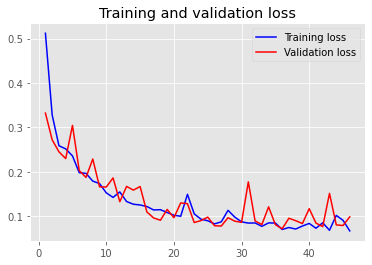

In [40]:
plot_history(history)

*Saving and loading the model*

In [42]:
model.save('saved_model/model.h5')

In [43]:
model = tf.keras.models.load_model('saved_model/model.h5')

### Inferences

In [44]:
# Making predictions on the testing data
predictions = model.predict(test_img_arr)
# Getting the accuracy
((predictions > 0.5).astype(int) == test_df.values[:,0].reshape(-1,1)).mean()

0.8413461538461539

The model predicted 84% accuracy on the testing dataset!

In [45]:
print(classification_report((predictions > 0.5).astype(int).flatten(), test_df.values[:,0].tolist(), target_names=['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.60      0.97      0.74       145
   Pneumonia       0.99      0.80      0.89       479

    accuracy                           0.84       624
   macro avg       0.79      0.88      0.81       624
weighted avg       0.90      0.84      0.85       624



In [46]:
os.stat('saved_model/model.h5').st_size

2064824

The model is only around ~2MB in size for having 84% accuracy!

### Visualizing the x-rays with the heat map

I will now visualize the last convolutional layer using the Grad-CAM Visualization method. This method uses the gradients of any target concept, flowing into the final convolutional layer to produce a coarse localization map highlighting important regions in the image for predicting the concept. 

https://arxiv.org/abs/1610.02391

The following code examples came from:<br>
Chollet François. (2021). Deep learning with python. Manning Publications. 

In [47]:
last_conv_layer_name = "add_3" # Getting the last Conv layer
classifier_layer_names = [ # Getting the remaining layers
    "flatten",
    "output",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = Model(model.inputs, last_conv_layer.output) # Creating a model to predict just the last conv layer

classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input 
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [48]:
def Visualizing_heatmaps(num):
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(test_img_arr[num].reshape(1,180,180,3)) 
        tape.watch(last_conv_layer_output) 
        preds = classifier_model(last_conv_layer_output) 
        top_pred_index = tf.argmax(preds[0]) 
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output) 

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy() 
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    for i in range(pooled_grads.shape[-1]): 
        last_conv_layer_output[:, :, i] *= pooled_grads[i] 
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    heatmap = np.uint8(255 * heatmap) 
    jet = cm.get_cmap("twilight") 
    jet_colors = jet(np.arange(256))[:, :3] 
    jet_heatmap = jet_colors[heatmap] 
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) 
    jet_heatmap = jet_heatmap.resize((test_img_arr[num].shape[1], 
                                      test_img_arr[num].shape[0])) 
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap) 
    superimposed_img = jet_heatmap * 0.0019 + test_img_arr[num]
    image = tf.keras.utils.array_to_img(superimposed_img)
    
    # Getting the actual labels
    actual_class = test_df.values[:,0].tolist()[num]
    pred_prob = model.predict(test_img_arr[num].reshape(1,180,180,3))[0][0]
    pred_class = int(pred_prob > 0.5)
    
    # Creating the title
    title = 'Predicted: '
    prob_title = ''
    if actual_class == 0:
        title += 'Normal\n'
    else:
        title += 'Pnemonia\n'
        
    if pred_class == 0:
        title += 'Actually Normal'
        prob_title = str(round((1 - pred_prob)*100,2))
    else:
        title += 'Actually Pnemonia'
        prob_title = str(round(pred_prob*100,2))
        
    title += '\nwith ' +prob_title+ '% probability'
    
    # Plotting the image
    plt.figure(figsize=(6,6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

**Showing the heatmaps**

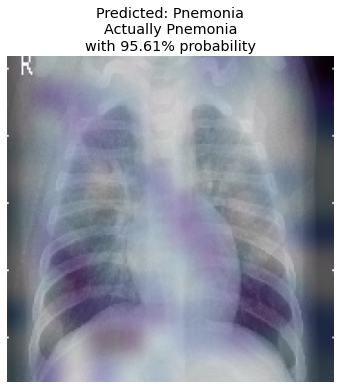

In [50]:
Visualizing_heatmaps(0)

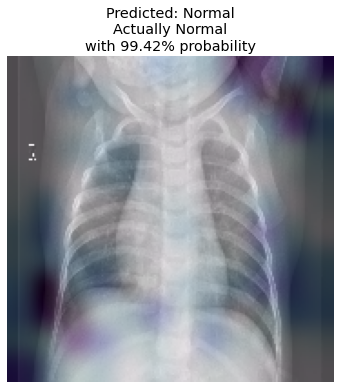

In [51]:
Visualizing_heatmaps(1)

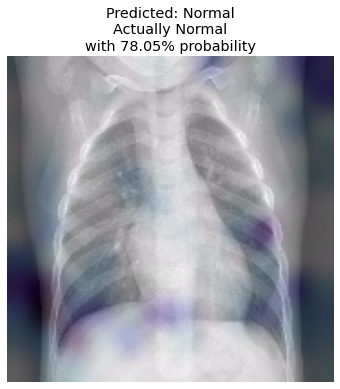

In [52]:
Visualizing_heatmaps(3)

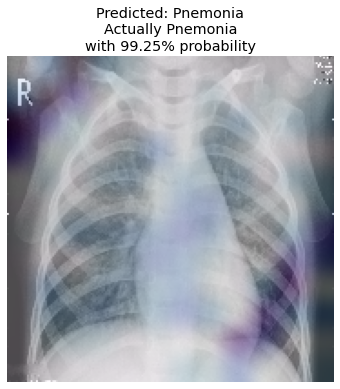

In [53]:
Visualizing_heatmaps(5)

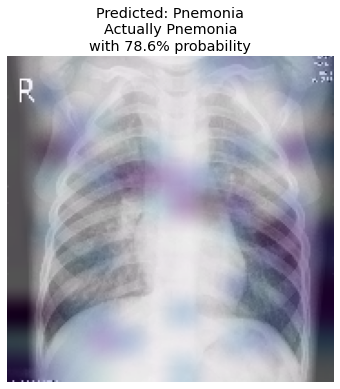

In [54]:
Visualizing_heatmaps(6)

### Limitations

While this method of visualization is helpful to generally understand where the models activations were strongest (i.e. what areas in the picture the model made it's predictions to), it is not a precise means of visualizing something like Pneumonia in a chest X-ray. I also only used an image that is 180 by 180 pixels. Many of the original images were thousands of pixels wide. This compression of images also leads to inaccurate heatmaps because fine details are being lost. 

Because I used residuals in the last convolutional layer, I believe this is causing the the excess heatmaps in the images themselves. Even though these images are cool to look at, they are not yet practicle in a clinical application due to the uncertaining present in the images.  

### Future work

Future work would include using a larger dataset, increasing the size of the images, and switching to a more state-of-the-art Vision Transformer model to produce more detailed heatmaps on the X-rays. Also, creating additional models to further classify what caused the pneumonia (i.e. kind of Virus, Bacteria & ARTD)